In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Particles"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using DynamicalSystems

function lorenz96_rule!(du, u, p, t)
    F = p[1]; N = length(u)
    # 3 edge cases
    du[1] = (u[2] - u[N - 1]) * u[N] - u[1] + F
    du[2] = (u[3] - u[N]) * u[1] - u[2] + F
    du[N] = (u[1] - u[N - 2]) * u[N - 1] - u[N] + F
    # then the general case
    for n in 3:(N - 1)
        du[n] = (u[n + 1] - u[n - 2]) * u[n - 1] - u[n] + F
    end
    return nothing # always `return nothing` for in-place form!
end

N = 6
u0 = range(0.1, 1; length = N)
p0 = [8.0]
lorenz96 = CoupledODEs(lorenz96_rule!, u0, p0)

total_time = 12.5
sampling_time = 0.02
Y, t = trajectory(lorenz96, total_time; Ttr = 2.2, Δt = sampling_time)
Y

6-dimensional StateSpaceSet{Float64} with 626 points
  3.15368   -4.40493  0.0311581  0.486735  1.89895   4.15167
  2.71382   -4.39303  0.395019   0.66327   2.0652    4.32045
  2.25088   -4.33682  0.693967   0.879701  2.2412    4.46619
  1.7707    -4.24045  0.924523   1.12771   2.42882   4.58259
  1.27983   -4.1073   1.08656    1.39809   2.62943   4.66318
  0.785433  -3.94005  1.18319    1.6815    2.84384   4.70147
  0.295361  -3.74095  1.2205     1.96908   3.07224   4.69114
 -0.181932  -3.51222  1.20719    2.25296   3.3139    4.62628
 -0.637491  -3.25665  1.154      2.5267    3.56698   4.50178
 -1.06206   -2.9781   1.07303    2.7856    3.82827   4.31366
 -1.44636   -2.68191  0.976951   3.02678   4.09314   4.05957
 -1.78148   -2.37508  0.87803    3.24925   4.35553   3.7392
 -2.05923   -2.06604  0.787251   3.45368   4.6082    3.35469
  ⋮                                                  ⋮
  3.07264    1.62792  2.25274    6.2994    8.10444   1.15856
  3.05063    1.83933  2.48345    6.6276

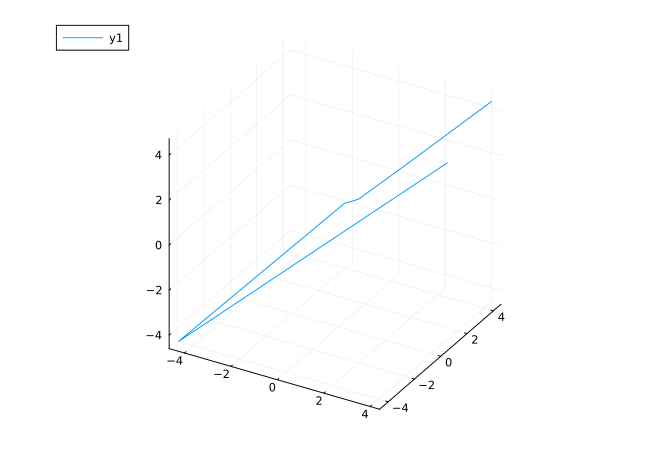

In [3]:
using Plots

plot(Y[1],Y[2],Y[3])